# Make hex Difference Maps

In [19]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import hvplot.pandas
import pickle
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [2]:
%matplotlib inline

In [60]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '12'

In [4]:
pd.set_option('display.max_columns', None)

## Load in the Data:

In [152]:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))
lakes_tuol = pickle.load(open('../../../data/misc/lakes_tuolumne.pkl', 'rb'))

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../../data/misc/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))

In [186]:
tuol_reverse = gpd.read_file('../../../data/misc/tuol_reverse.geojson')

In [187]:
tuol_reverse = tuol_reverse.to_crs('epsg:32611')

In [188]:
tuol_reverse = gpd.overlay(tuol_reverse, outline_gdf, how='difference')

<AxesSubplot: >

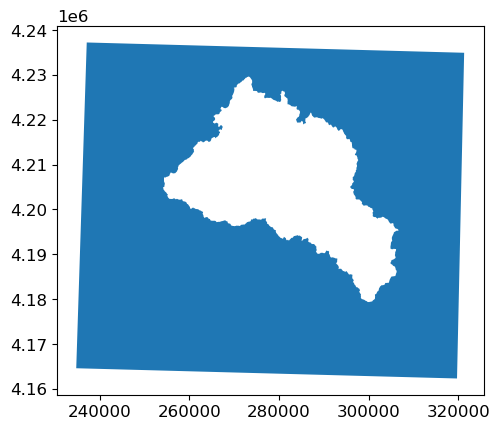

In [189]:
tuol_reverse.plot()

## Filter Outliers  
Using David's code  
Less concerned about doing this since I use the Median in my anayses

In [110]:
atl06sr_gdf[atl06sr_gdf['snow_presence']==0]['zscore']

time
2018-10-15 23:22:20.018965444     
2018-10-15 23:22:20.021811344     
2018-10-15 23:22:20.027481712     
2018-10-15 23:22:20.030305900     
2018-10-15 23:22:20.033126928     
                                ..
2022-06-06 07:52:14.166292256     
2022-06-06 07:52:14.174719728     
2022-06-06 07:52:14.177525200     
2022-06-06 07:52:14.183137424     
2022-06-06 07:52:14.185946192     
Name: zscore, Length: 64917, dtype: object

In [153]:
atl06sr_gdf.loc[atl06sr_gdf['snow_presence']==0,'zscore'] = (atl06sr_gdf.loc[atl06sr_gdf['snow_presence']==0,'diff_plus'] - atl06sr_gdf.loc[atl06sr_gdf['snow_presence']==0,'diff_plus'].mean()) / atl06sr_gdf.loc[atl06sr_gdf['snow_presence']==0,'diff_plus'].std()

atl06sr_gdf.loc[atl06sr_gdf['snow_presence']==1,'zscore'] = (atl06sr_gdf.loc[atl06sr_gdf['snow_presence']==1,'diff_plus'] - atl06sr_gdf.loc[atl06sr_gdf['snow_presence']==1,'diff_plus'].mean()) / atl06sr_gdf.loc[atl06sr_gdf['snow_presence']==1,'diff_plus'].std()


In [140]:
atl06sr_gdf['zscore']

time
2018-10-15 23:22:20.018965444   -0.014777
2018-10-15 23:22:20.021811344   -0.003536
2018-10-15 23:22:20.027481712   -0.006962
2018-10-15 23:22:20.030305900    0.001616
2018-10-15 23:22:20.033126928   -0.014566
                                   ...   
2022-06-06 07:52:14.166292256         NaN
2022-06-06 07:52:14.174719728         NaN
2022-06-06 07:52:14.177525200         NaN
2022-06-06 07:52:14.183137424         NaN
2022-06-06 07:52:14.185946192         NaN
Name: zscore, Length: 152004, dtype: float64

In [141]:
atl06sr_gdf.zscore.describe()

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


count    1.494500e+05
mean    -1.939789e-17
std      9.999967e-01
min     -1.296333e+01
25%     -1.620082e-01
50%     -9.095803e-03
75%      1.069909e-01
max      1.458814e+02
Name: zscore, dtype: float64

In [154]:
#atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus'] - atl06sr_gdf['diff_plus'].mean()) / atl06sr_gdf['diff_plus'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [157]:
# trying to get different zscore values for snow on versus snow off values

atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [28]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= atl06sr_gdf[atl06sr_gdf['snow_presence'] == 1].median() + absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

### Create the hex map using code from GDA 2021

<AxesSubplot: >

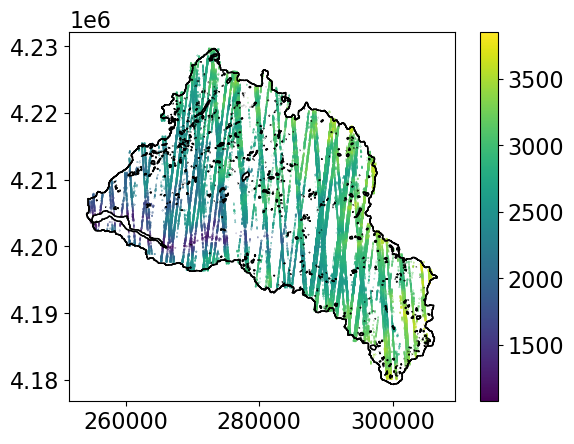

In [28]:
fig, ax = plt.subplots()

atl06sr_gdf.plot(ax=ax, column='h_mean', markersize=0.01, legend=True)
outline_nolakes.plot(ax=ax, facecolor='none')

<AxesSubplot: >

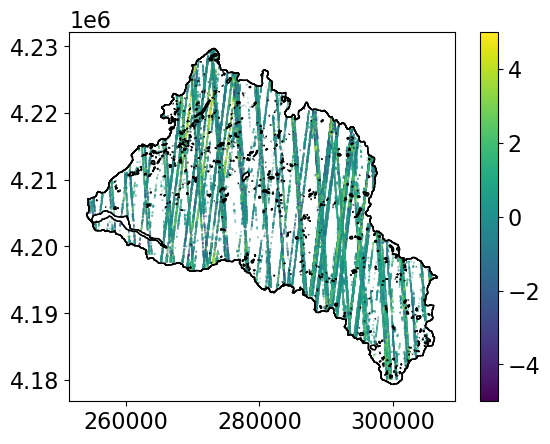

In [38]:
fig, ax = plt.subplots()

atl06sr_gdf[atl06_idx].plot(ax=ax, column='diff_plus', markersize=0.01, legend=True)
outline_nolakes.plot(ax=ax, facecolor='none')

Text(0.5, 1.0, 'ATL06SR Snow On - DEM')

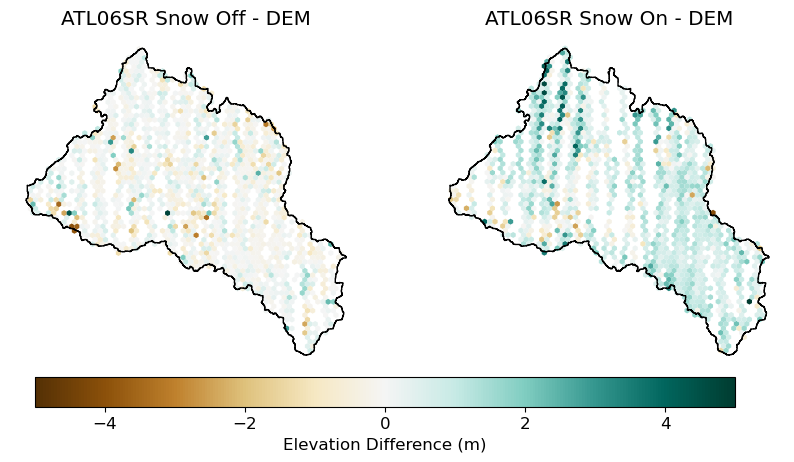

In [214]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

hb_off = ax[0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='none')

hb_on = ax[1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='none')

outline_gdf.plot(ax=ax[0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[1], facecolor='none', edgecolor='k')

for axis in ax:
    axis.set_axis_off()

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.25, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0].set_title('ATL06SR Snow Off - DEM')
ax[1].set_title('ATL06SR Snow On - DEM')

In [100]:
cmap(0)

(0.32941176470588235, 0.18823529411764706, 0.0196078431372549, 1.0)

In [102]:
cmap(1000)

(0.0, 0.23529411764705882, 0.18823529411764706, 1.0)

In [116]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks/figure_production


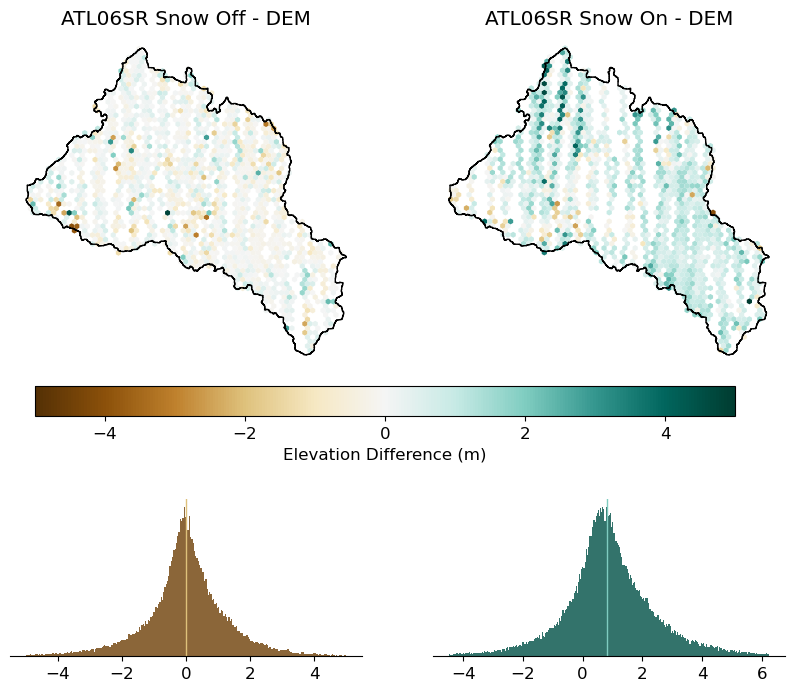

In [215]:
# add histograms to difference plots
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.get_cmap('BrBG')

fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1], 'width_ratios': [1,1]})

hb_off = ax[0,0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='none')
ax[0,0].set_axis_off()

hb_on = ax[0,1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, edgecolors='none', vmin=-5, vmax=5)
ax[0,1].set_axis_off()

outline_gdf.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[0,1], facecolor='none', edgecolor='k')

ax[1,0].hist(atl06sr_gdf[inner_snowoff_idx]['diff_plus'], color=cmap(norm(-4.5)),\
            bins=int(np.sqrt(len(atl06sr_gdf[inner_snowoff_idx]))), alpha=0.8)
ax[1,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-2)), linewidth=1)
#ax[1,0].set_xlabel('Snowoff Elevation Differences (m)')
# Hide the right and top spines
ax[1,0].spines.right.set_visible(False)
ax[1,0].spines.top.set_visible(False)
ax[1,0].spines.left.set_visible(False)
ax[1,0].axes.yaxis.set_visible(False)

ax[1,1].hist(atl06sr_gdf[inner_snowon_idx]['diff_plus'], color=cmap(norm(4.5)),\
            bins=int(np.sqrt(len(atl06sr_gdf[inner_snowon_idx]))), alpha=0.8)
ax[1,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(2)), linewidth=1)
#ax[1,1].set_xlabel('Snow On Elevation Differences (m)')
ax[1,1].spines.right.set_visible(False)
ax[1,1].spines.top.set_visible(False)
ax[1,1].spines.left.set_visible(False)
ax[1,1].axes.yaxis.set_visible(False)

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0,0].set_title('ATL06SR Snow Off - DEM')
ax[0,1].set_title('ATL06SR Snow On - DEM')

plt.savefig('../../figures/polished/difference_map_hist.jpeg', dpi=500)

## Add another Row with Hillshade and other characteristics

In [58]:
hillshade = rxr.open_rasterio('../../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_100m_hillshade.tif', masked=True).squeeze()
chm = rxr.open_rasterio('../../../data/lidar/tuolumne/chm/USCATB20140827_chm_3p0m_ma_100m.tif', masked=True).squeeze()

In [112]:
# from: https://data.cnra.ca.gov/dataset/nhd-major-features

streamlines = gpd.read_file('../../../data/misc/nhd_major_rivers_and_creeks/Major_Rivers_and_Creeks.shp')

In [168]:
dtm = rxr.open_rasterio('../../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_100m.tif', masked=True).squeeze()

In [113]:
streamlines = streamlines.to_crs('epsg:32611')

In [114]:
streamlines_tuol = gpd.clip(streamlines, outline_gdf)

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

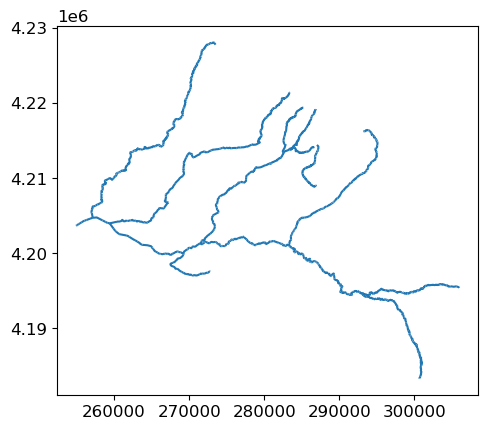

In [116]:
streamlines_tuol.plot()

In [78]:
hetch_hetchy = lakes_tuol[lakes_tuol['NAME'] == 'Hetch Hetchy Reservoir']

In [147]:
int(np.sqrt(len(atl06sr_gdf[inner_snowoff_idx])))

252

In [148]:
int(np.sqrt(len(atl06sr_gdf[inner_snowon_idx])))

290

Text(0.5, 1.0, 'Tuolumne All Data')

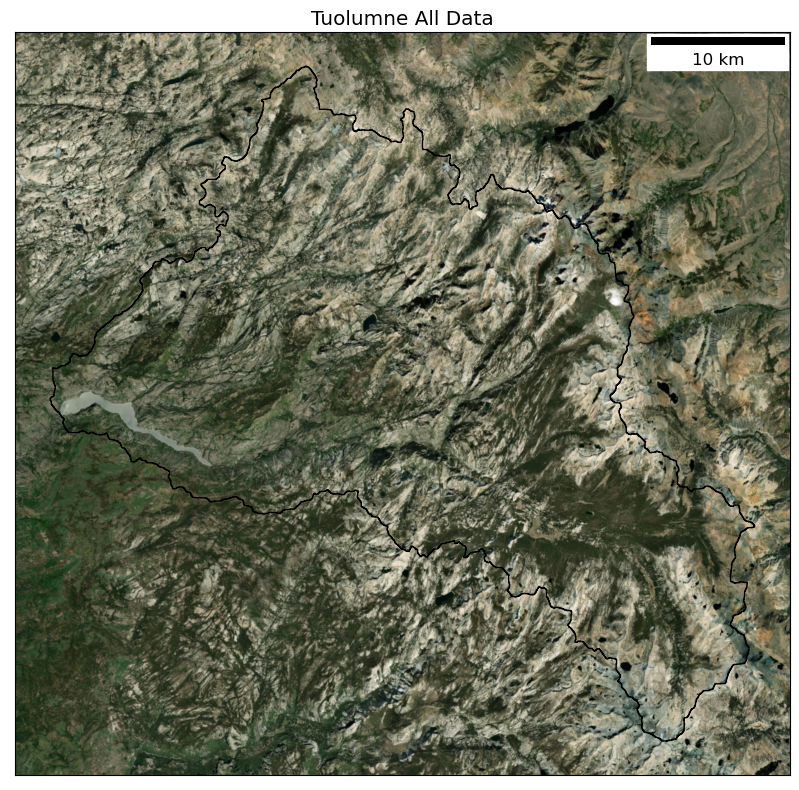

In [180]:
basemap = cx.providers.Esri.WorldImagery
#basemap.update({'time':'2019-09-09'})

f, axa = plt.subplots(figsize=(10,10))
s=10

#atl06sr_gdf.plot(ax=axa, column='diff_plus', cmap='RdBu', legend = False, s=s, vmin = -4, vmax = 4)
outline_gdf.plot(ax=axa, facecolor='none', edgecolor='k')
axa.add_artist(ScaleBar(1))
cx.add_basemap(axa, attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=12)
axa.axes.xaxis.set_ticks([])
axa.axes.yaxis.set_ticks([])
    
#axa.set_title('Tuolumne All Data')

#plt.savefig('../figures/difmap_alldata.jpeg', dpi=500)

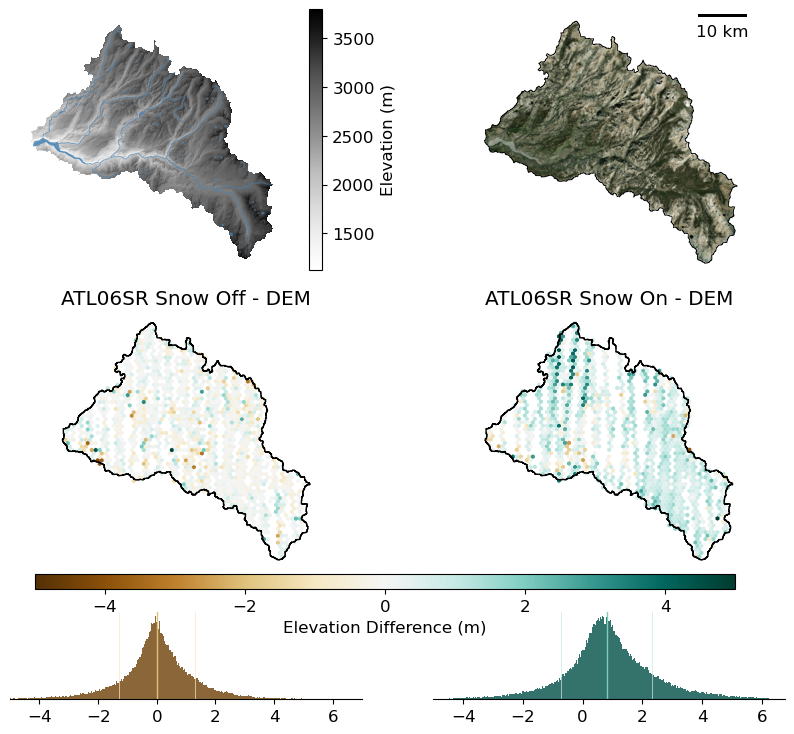

In [224]:
# add histograms to difference plots
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.get_cmap('BrBG')

fig, ax = plt.subplots(3,2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 3, 1], 'width_ratios': [1,1]})

c = dtm.plot(cmap='Greys', ax=ax[0,0], add_colorbar=True, cbar_kwargs={'label':'Elevation (m)'})
#chm.plot(cmap='Greens', ax=ax[0,0], add_colorbar=True, vmin=0, vmax=20, cbar_kwargs={'label':'Canopy Height (m)','shrink':0.9}, alpha=0.8)
hillshade.plot(cmap='Greys', ax=ax[0,0], add_colorbar=False, alpha=0.2)
lakes_tuol.plot(ax=ax[0,0], color='steelblue', alpha=0.8)
streamlines_tuol.plot(ax=ax[0,0], color='steelblue', linewidth=0.5, alpha=0.8)
ax[0,0].set_xlim(250000, 310000)
ax[0,0].set_ylim(4178000, 4232000)
ax[0,0].set_axis_off()
ax[0,0].set_title('')
ax[0,1].set_axis_off()
ax[0,1].set_title('')
c.set_label('Canopy Height(m)')
#ig.colorbar(c, label = 'Canopy Height (m)')

ax[0,1].add_artist(ScaleBar(1))
outline_gdf.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
cx.add_basemap(ax[0,1], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=12)
tuol_reverse.plot(ax=ax[0,1], facecolor='white')
ax[0,1].set_xlim(250000, 310000)
ax[0,1].set_ylim(4178000, 4232000)
ax[0,1].axes.xaxis.set_ticks([])
ax[0,1].axes.yaxis.set_ticks([])

hb_off = ax[1,0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='none')
ax[1,0].set_axis_off()

hb_on = ax[1,1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, edgecolors='none', vmin=-5, vmax=5)
ax[1,1].set_axis_off()

outline_gdf.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[1,1], facecolor='none', edgecolor='k')

ax[2,0].hist(atl06sr_gdf[inner_snowoff_idx]['diff_plus'], color=cmap(norm(-4.5)),\
            bins=252, alpha=0.8)
ax[2,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-2)), linewidth=1)
#add lines for the standard deviation
ax[2,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
                np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)
ax[2,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) - 
                np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)
#ax[1,0].set_xlabel('Snowoff Elevation Differences (m)')
# Hide the right and top spines
ax[2,0].spines.right.set_visible(False)
ax[2,0].spines.top.set_visible(False)
ax[2,0].spines.left.set_visible(False)
ax[2,0].axes.yaxis.set_visible(False)
ax[2,0].set_xlim(-5,7)
# ax[2,0].text(x=np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), y=0, s='std')
# ax[2,0].text(x=np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), y=0, s='median')

ax[2,1].hist(atl06sr_gdf[inner_snowon_idx]['diff_plus'], color=cmap(norm(4.5)),\
            bins=290, alpha=0.8)
ax[2,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(2)), linewidth=1)
ax[2,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) + 
                np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)
ax[2,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) -
                np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)
#ax[1,1].set_xlabel('Snow On Elevation Differences (m)')
ax[2,1].spines.right.set_visible(False)
ax[2,1].spines.top.set_visible(False)
ax[2,1].spines.left.set_visible(False)
ax[2,1].axes.yaxis.set_visible(False)

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.015])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[1,0].set_title('ATL06SR Snow Off - DEM', y=1.1, pad=-14)
ax[1,1].set_title('ATL06SR Snow On - DEM', y=1.1, pad=-14)

plt.savefig('../../figures/polished/difference_map_hist_w-hillshade.jpeg', dpi=500)

In [220]:
np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus'])

0.804356721198701

In [ ]:
# should i report the iqr instead of std for consistency with table 1? more resistant to outliers.

In [221]:
from scipy import stats

def iqr2(x):
    IQR = stats.iqr(x, interpolation = 'midpoint')
    return IQR

In [222]:
iqr2(atl06sr_gdf[inner_snowon_idx]['diff_plus'])

1.5704840071178978

In [223]:
iqr2(atl06sr_gdf[inner_snowoff_idx]['diff_plus'])

1.2430893767943871

## Try out a kernel density estimator to check the spread of measurements

In [78]:
import seaborn as sns

(array([240000., 260000., 280000., 300000., 320000.]),
 [Text(240000.0, 0, '240000'),
  Text(260000.0, 0, '260000'),
  Text(280000.0, 0, '280000'),
  Text(300000.0, 0, '300000'),
  Text(320000.0, 0, '320000')])

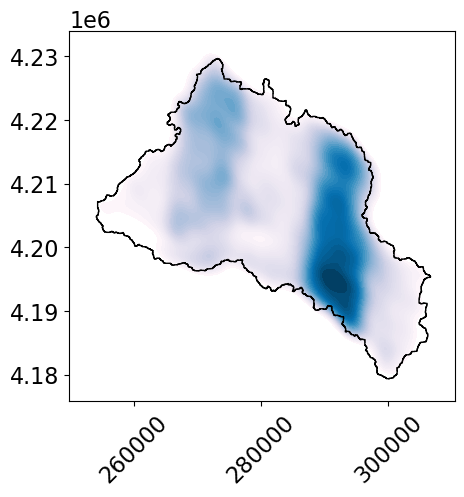

In [84]:
f, ax = plt.subplots()

kde = sns.kdeplot(data='diff_plus', x=atl06sr_gdf.geometry.x, y=atl06sr_gdf.geometry.y, fill=True, legend=True, cmap='PuBu', levels=50, ax=ax)

#plt.colorbar(kde, label='Point Density')

outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

plt.xticks(rotation=45)
#plt.title('GLAS Kernel Density Estimator')